## Perform Clustering Using Manifolder on Themis Data

In [7]:
# useful set of python imports

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set()
import pandas as pd
import time
import os
import pickle
from sklearn.model_selection import train_test_split
import more_itertools as mit
from manifolder.plotting import plot_clusters
import pandas as pd

def separator(char='-', n=42):
    print(char*n)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Themis Data with Bounding box Information
- 104 Data samples with 15 variables and 1440 time step


In [8]:
# For Train Test SPlit
random_state = 3

#Load Data
segments = np.load('themis/segments-newdata-all.npy')

# Load Labels
labels = np.load('themis/labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)


In [3]:
segments.shape

(104, 1440, 15)

In [4]:
labels.shape

(104, 2)

### Import Manifolder

In [9]:
import manifolder as mr

In [10]:
list(segments)[0].shape

(1440, 15)

In [11]:
# converting into list of MVTS
# zs = list(segments)

In [12]:
# Prepare the data
zs_0 = []
zs_1 = []
zs_0_boxes = []
zs_1_boxes = []
for i,label in enumerate(labels):
    if label[1] == 1:
        zs_1.append(segments[i])
        zs_1_boxes.append(bboxes[i])
    else:
        zs_0.append([i])
        zs_0_boxes.append(bboxes[i])
z_breakpoint = len(zs_0)

In [13]:
zs = zs_0 + zs_1
z_breakpoint = len(zs_0)

### Run manifolder

In [10]:
# data has been parsed, now run Manifolder

H = 80
step_size = 10

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(H=H,step_size=step_size,nbins=10, ncov=20)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs)
elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)

calculating histograms for snip  0  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  1  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  2  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  3  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  4  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  5  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  6  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  7  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  8  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  9  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  10  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip

running k-means
(14152,)
normalizing amplitudes of Psi in Python ...
(14144,)
done


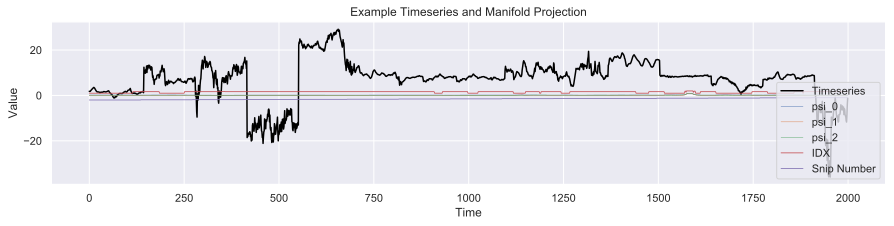

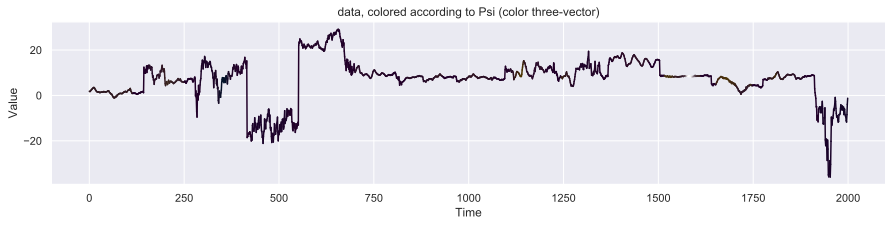


	 Program Executed for k means clustering in 5.56 seconds


In [70]:
start_time = time.time()

manifolder._clustering(numClusters=12)  # display

elapsed_time = time.time() - start_time
print('\n\t Program Executed for k means clustering in', str(np.round(elapsed_time, 2)), 'seconds')

In [71]:
from manifolder import helper as mh

In [72]:
# clustering data for k-means...

IDX = manifolder.IDX
# cluster_lens = mh.count_cluster_lengths(IDX)

# # cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# # and the values are a list of cluster lengths

# mh.show_cluster_lens(cluster_lens)

In [73]:
manifolder.Psi.shape

(14144, 9)

In [74]:
manifolder.snip_number

array([  0.,   0.,   0., ..., 103., 103., 103.])

In [75]:
z_breakpoint

47

In [76]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)

M_z0 = mh.make_transition_matrix(IDX[manifolder.snip_number<z_breakpoint])
M_z1 = mh.make_transition_matrix(IDX[manifolder.snip_number>=z_breakpoint])

print('\n z0 transition matrix:')
print(M_z0)

print('\n z1 transition matrix:')
print(M_z1)


 transition matrix:
[[ 543.    0.    0.    0.    0.    0.   11.    0.    1.    0.    0.    0.]
 [   0. 9042.    0.    1.    0.    5.    1.    5.    0.    0.    0.   64.]
 [   0.    0.   54.    0.    0.    0.    0.    0.    0.    0.    1.    0.]
 [   0.    0.    0.   80.    0.    2.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.   33.    0.    0.    0.    2.    1.    0.    0.]
 [   0.    8.    0.    1.    0.  387.    0.    0.    0.    0.    0.   10.]
 [  12.    0.    0.    0.    0.    0. 1394.    1.    0.    0.    0.    0.]
 [   0.    2.    0.    0.    0.    0.    1.  258.    3.    0.    0.    5.]
 [   1.    1.    0.    0.    2.    0.    0.    2.   70.    0.    0.    0.]
 [   0.    0.    0.    0.    1.    0.    0.    0.    0.   17.    0.    0.]
 [   0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   58.    3.]
 [   0.   64.    0.    0.    0.   12.    0.    3.    0.    0.    3. 1977.]]

 z0 transition matrix:
[[ 543.    0.    0.    0.    0.    0.   11.    0.    1

In [77]:
z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(len(IDX),1), 1)
z_downsample = np.append(z_downsample, IDX.reshape(len(IDX),1), 1)
    
z_downsample.shape

(14144, 18)

In [78]:
z_downsample

array([[  1.83,  -1.63,  10.53, ...,   0.  ,   0.  ,   0.  ],
       [  1.75,  -1.56,  10.56, ...,   0.  ,   0.  ,   0.  ],
       [  1.74,  -1.93,  10.42, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  1.23,  -3.47,  43.65, ...,   1.  , 103.  ,   1.  ],
       [  0.29,  -1.72,  43.57, ...,   1.  , 103.  ,   1.  ],
       [ -1.18,  -1.84,  43.21, ...,   1.  , 103.  ,   1.  ]])

In [92]:
np.savetxt('astro_subset2_clustering_k=12_FTE.csv', z_downsample, delimiter=',', fmt='%f')

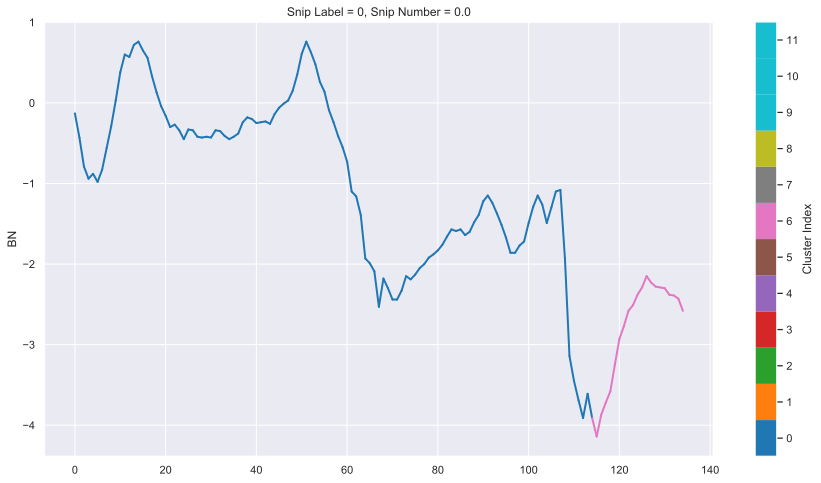

In [86]:
from manifolder.plotting import plot_clusters
import pandas as pd
df = pd.read_csv('astro_subset2_clustering_k=12_FTE.csv')
df.columns = ['Bx', 'By', 'Bz', 'BL', 'BM', 'BN',
              'Bmaд', 'Vx', 'Vy', 'Vz', 'Vmaд',
              'np', 'Tpar', 'Tper', 'Tp', 'Snip Label',
              'Snip Number', 'Cluster Index']
snip_label = 0
i = 0
for snip_number in df[df['Snip Label'] == snip_label]['Snip Number'].unique():
    i+=1
    selected = df[(df['Snip Label'] == snip_label)  & (df['Snip Number'] == snip_number)]
    data = selected['BN']
    labels = selected['Cluster Index']
    n_clusters = max(df['Cluster Index']) + 1
    fig, ax = plt.subplots(figsize=(15, 8))
    plot_clusters(
        data.index, data.values, labels,
        n_clusters=n_clusters, cbar_label='Cluster Index',
        ax=ax, lw=2
    )
    ax.set_ylabel(data.name)
    ax.set_title(f"Snip Label = {snip_label}, Snip Number = {snip_number}")
    fig.savefig(f'{i}.png')

    break

    

## Perform Evaluation

In [93]:
# Helper Functions
def find_ranges(iterable, upsampling_coef):
    """Yield range of cluster bounds"""
    for group in mit.consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            yield int(group[0] * upsampling_coef)
        else:
            yield int(group[0] * upsampling_coef), int(group[-1] * upsampling_coef)
            
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    xB = min(boxA[1], boxB[1])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[1] - boxA[0] + 1) 
    boxBArea = (boxB[1] - boxB[0] + 1) 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def get_max_iou(gt_box, target_boxes):
    iou = 0.
    for box in target_boxes:
        iou = max(bb_intersection_over_union(box, [gt_box[0,0], gt_box[0,2]]), iou)
    return iou

## Evaluate on Positive Sample
- If there is atleast overlap compute max IOU


In [94]:

df = pd.read_csv('astro_subset2_clustering_k=12_FTE.csv')
df.columns = ['Bx', 'By', 'Bz', 'BL', 'BM', 'BN',
              'Bmaд', 'Vx', 'Vy', 'Vz', 'Vmaд',
              'np', 'Tpar', 'Tper', 'Tp', 'Snip Label',
              'Snip Number', 'Cluster Index']
snip_label = 1
IOU = {}
upsampling_coef = 1440./len(labels)
index = 0
target_cluster = 1
for snip_number in df[df['Snip Label'] == snip_label]['Snip Number'].unique():
    gt_box = zs_1_boxes[index]
    
    # Get Labels
    selected = df[(df['Snip Label'] == snip_label)  & (df['Snip Number'] == snip_number)]
    labels = selected['Cluster Index']
    
    # Find Boxes
    labels_taget_cluster = np.where(labels==target_cluster)[0]
    target_boxes = list(find_ranges(labels_taget_cluster, upsampling_coef))
    
    IOU[index] = get_max_iou(gt_box, target_boxes)
    index+=1
   

In [95]:
np.mean(list(IOU.values()))

0.31442528658542557

In [96]:
IOU

{0: 0.267689792715621,
 1: 0.32066872582522826,
 2: 0.6008900936262807,
 3: 0.752605887863101,
 4: 0.2417228739002934,
 5: 0.2127107771260998,
 6: 0.16308032316609106,
 7: 0.17452819837612465,
 8: 0.18044662351240806,
 9: 0.19262547935935034,
 10: 0.13460128581096317,
 11: 0.10558918903676971,
 12: 0.2073027617163725,
 13: 0.06988199300699308,
 14: 0.8052488479262677,
 15: 0.3369356301439327,
 16: 0.12344278705165819,
 17: 0.10558918903676971,
 18: 0.2857903366548446,
 19: 0.8016238808985633,
 20: 0.1346012858109633,
 21: 0.28906127417047417,
 22: 0.3032277487724532,
 23: 0.28636225308471225,
 24: 0.0,
 25: 0.3553086176649601,
 26: 0.5188135814277023,
 27: 0.1301378863072412,
 28: 0.23061254077564336,
 29: 0.13013788630724124,
 30: 0.4024623215230037,
 31: 0.21047907737423888,
 32: 0.5515537131996517,
 33: 0.09219899052560343,
 34: 0.3421493627340403,
 35: 0.27234681187820325,
 36: 0.27296667042634787,
 37: 0.5301430015979229,
 38: 0.13460128581096326,
 39: 0.23056437514098813,
 40: 0.

## Evaluate on Negative Samples
- If there is target cluster ID, count as False Positive

In [100]:
df = pd.read_csv('astro_subset2_clustering_k=12_FTE.csv')
df.columns = ['Bx', 'By', 'Bz', 'BL', 'BM', 'BN',
              'Bmaд', 'Vx', 'Vy', 'Vz', 'Vmaд',
              'np', 'Tpar', 'Tper', 'Tp', 'Snip Label',
              'Snip Number', 'Cluster Index']
snip_label = 0
IOU = {}
upsampling_coef = 1440./len(labels)
index = 0
target_cluster = 1
FP = 0
for snip_number in df[df['Snip Label'] == snip_label]['Snip Number'].unique():
    gt_box = zs_0_boxes[index]
    
    # Get Labels
    selected = df[(df['Snip Label'] == snip_label)  & (df['Snip Number'] == snip_number)]
    labels = selected['Cluster Index']
    
    # Find Boxes
    labels_taget_cluster = np.where(labels==target_cluster)[0]
    target_boxes = list(find_ranges(labels_taget_cluster, upsampling_coef))
    print(target_boxes)
    if len(target_boxes)>0:
        FP+=1

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1016, 1429)]
[(0, 1429)]
[(0, 201), (1217, 1429)]
[(0, 1429)]
[(0, 201), (900, 1429)]
[(0, 201), (1217, 1429)]
[(0, 201), (1217, 1429)]
[(0, 201), (1217, 1429)]
[(0, 201), (1217, 1429)]
[(0, 497), (1217, 1429)]
[(0, 1429)]
[(0, 1429)]
[(0, 201), (1217, 1429)]
[(0, 201), (1164, 1429)]
[(0, 201), (1217, 1429)]
[(0, 1429)]
[(0, 1429)]
[(0, 201), (1217, 1429)]
[(0, 518), (656, 1429)]
[(0, 1429)]
[(0, 1429)]
[(0, 1429)]
[(0, 201), (1217, 1429)]
[(0, 201), (1217, 1429)]
[(0, 529), (794, 1429)]
[(0, 201), (1217, 1429)]
[(0, 201), (1217, 1429)]
[(0, 201), (995, 1132), (1217, 1429)]
[(0, 201), (370, 624), (1122, 1429)]
[(0, 201), (1217, 1429)]
[(0, 1429)]
[(0, 751), (783, 1429)]
[(0, 656), (952, 1429)]


In [102]:
FP, len(zs_0_boxes)

(33, 47)